In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import time
import datetime
from dateutil import parser
import matplotlib.dates as mdates
import matplotlib.ticker as plticker

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

#np.set_printoptions(threshold=np.inf)

# Load the dataset

In [2]:
org_df = pd.read_csv('FinalData.csv',index_col=0)

In [3]:
org_df

,P_Neg,P_Neu,P_Pos,P_Comp,open_BTCUSD,high_BTCUSD,low_BTCUSD,close_BTCUSD,volume_BTCUSD,close_ETHUSD,volume_ETHUSD,close_LTCUSD,volume_LTCUSD,reddit_flair,reddit_tb_polarity,reddit_tb_subjectivity,reddit_sid_pos,reddit_sid_neg,reddit_sid_neu,reddit_sid_com
timestamp,,,,,,,,,,,,,,,,,,,,
2018/10/1 0:00,0.000,0.000,0.000,0.0000,6597.81,6624.79,6597.77,6623.02,1.195874e+06,232.42,131905.060000,61.47,55712.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2018/10/1 1:00,0.000,0.000,0.000,0.0000,6623.02,6638.15,6600.31,6606.85,2.005263e+06,232.62,89554.370000,61.26,79309.160000,-0.997752,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
2018/10/1 2:00,0.000,0.000,0.000,0.0000,6606.85,6618.90,6599.20,6605.10,6.024125e+05,232.08,96407.680000,61.44,9026.950000,0.004097,0.132727,0.249091,0.039000,0.000000,0.961000,0.012900
2018/10/1 3:00,0.000,0.000,0.000,0.0000,6605.10,6628.95,6605.10,6618.96,4.804891e+05,232.01,109914.020000,61.40,44891.100000,-0.058698,0.091667,0.195833,0.296250,0.061250,0.642500,0.467400
2018/10/1 4:00,0.000,0.000,0.000,0.0000,6618.96,6630.80,6596.33,6600.34,6.385462e+05,230.73,106138.770000,61.11,35443.300000,-0.995512,0.233750,0.843750,0.229000,0.000000,0.771000,0.745600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022/9/30 20:00,0.000,0.807,0.193,0.5789,19486.00,19535.00,19364.00,19422.00,9.253103e+01,1331.70,564.578251,53.35,858.571622,-0.880913,0.117629,0.574544,0.063000,0.016333,0.920667,0.483067
2022/9/30 21:00,0.000,0.000,0.000,0.0000,19411.00,19419.00,19295.00,19361.00,4.540571e+01,1323.30,298.016971,53.16,749.608425,0.497723,-0.006597,0.131944,0.264750,0.000000,0.735250,0.601500
2022/9/30 22:00,0.000,0.000,0.000,0.0000,19356.00,19400.00,19243.00,19387.00,4.342626e+01,1322.60,366.432173,53.26,319.758191,-0.592397,0.134028,0.245139,0.163250,0.095750,0.741000,-0.200225


In [4]:
org_df.columns

Index(['P_Neg', 'P_Neu', 'P_Pos', 'P_Comp', 'open_BTCUSD', 'high_BTCUSD',
       'low_BTCUSD', 'close_BTCUSD', 'volume_BTCUSD', 'close_ETHUSD',
       'volume_ETHUSD', 'close_LTCUSD', 'volume_LTCUSD', 'reddit_flair',
       'reddit_tb_polarity', 'reddit_tb_subjectivity', 'reddit_sid_pos',
       'reddit_sid_neg', 'reddit_sid_neu', 'reddit_sid_com'],
      dtype='object')

# Features engineering

In [5]:
org_df['flair'] = org_df['reddit_flair']
org_df['tb_polarity'] = org_df['reddit_tb_polarity']
org_df['tb_subjectivity'] = org_df['reddit_tb_subjectivity']
org_df['sid_pos'] = org_df['reddit_sid_pos']
org_df['sid_neg'] = org_df['reddit_sid_neg']
org_df = org_df[['open_BTCUSD','high_BTCUSD','low_BTCUSD', 'close_BTCUSD', 'volume_BTCUSD', 'close_LTCUSD', 'volume_LTCUSD', 'close_ETHUSD', 'volume_ETHUSD', 'flair', 'tb_polarity', 'tb_subjectivity', 'sid_pos', 'sid_neg']]

In [6]:
org_df

,open_BTCUSD,high_BTCUSD,low_BTCUSD,close_BTCUSD,volume_BTCUSD,close_LTCUSD,volume_LTCUSD,close_ETHUSD,volume_ETHUSD,flair,tb_polarity,tb_subjectivity,sid_pos,sid_neg
timestamp,,,,,,,,,,,,,,
2018/10/1 0:00,6597.81,6624.79,6597.77,6623.02,1.195874e+06,61.47,55712.420000,232.42,131905.060000,0.000000,0.000000,0.000000,0.000000,0.000000
2018/10/1 1:00,6623.02,6638.15,6600.31,6606.85,2.005263e+06,61.26,79309.160000,232.62,89554.370000,-0.997752,0.000000,0.000000,0.000000,0.000000
2018/10/1 2:00,6606.85,6618.90,6599.20,6605.10,6.024125e+05,61.44,9026.950000,232.08,96407.680000,0.004097,0.132727,0.249091,0.039000,0.000000
2018/10/1 3:00,6605.10,6628.95,6605.10,6618.96,4.804891e+05,61.40,44891.100000,232.01,109914.020000,-0.058698,0.091667,0.195833,0.296250,0.061250
2018/10/1 4:00,6618.96,6630.80,6596.33,6600.34,6.385462e+05,61.11,35443.300000,230.73,106138.770000,-0.995512,0.233750,0.843750,0.229000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022/9/30 20:00,19486.00,19535.00,19364.00,19422.00,9.253103e+01,53.35,858.571622,1331.70,564.578251,-0.880913,0.117629,0.574544,0.063000,0.016333
2022/9/30 21:00,19411.00,19419.00,19295.00,19361.00,4.540571e+01,53.16,749.608425,1323.30,298.016971,0.497723,-0.006597,0.131944,0.264750,0.000000
2022/9/30 22:00,19356.00,19400.00,19243.00,19387.00,4.342626e+01,53.26,319.758191,1322.60,366.432173,-0.592397,0.134028,0.245139,0.163250,0.095750


In [7]:
dataset = org_df.values
dataset = dataset.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
num_of_features = len(org_df.columns)
print('Number of features', num_of_features)

Number of features 14


# Configuration

In [8]:
expr_name = 'expr_4'
look_back = 24*120 # 60 days, as each entry is for 1 hour
lstm_layers = 64
epochs=12
batch_size=128

# spliting datasets into train and test

In [9]:
train_size_percent = 0.80
pred_col = org_df.columns.get_loc('close_BTCUSD')

# function to split the data
def create_dataset(dataset, pred_col, look_back=1):
  dataX, dataY = [], []
  for i in range(len(dataset)-look_back-1):
    a = dataset[i:(i+look_back), :]
    dataX.append(a)
    dataY.append(dataset[i + look_back, pred_col])
  return np.array(dataX), np.array(dataY)


train_size = int(len(dataset) * train_size_percent)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]

trainX, trainY = create_dataset(train, pred_col, look_back=look_back)
testX, testY = create_dataset(test, pred_col, look_back=look_back)
# reshape input to be  [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], look_back, num_of_features))
testX = np.reshape(testX, (testX.shape[0],look_back, num_of_features))

print('Training dataset length ', len(train))
print('Testing dataset length ', len(test))
print('look_back ', look_back)

Training dataset length  28052
Testing dataset length  7013
look_back  2880


# Build the model and train

In [10]:
# create and fit the LSTM network

model = Sequential()
model.add(LSTM(lstm_layers, input_shape=(look_back,num_of_features)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history= model.fit(trainX, trainY,validation_split=0.30, epochs=epochs, batch_size=batch_size,shuffle=False)

Epoch 1/12
138/138 [==============================] - 30s 163ms/step - loss: 6.9206e-04 - val_loss: 0.0380
Epoch 2/12
138/138 [==============================] - 21s 154ms/step - loss: 0.0017 - val_loss: 0.0171
Epoch 3/12
138/138 [==============================] - 24s 173ms/step - loss: 0.0020 - val_loss: 0.0116
Epoch 4/12
138/138 [==============================] - 21s 154ms/step - loss: 0.0017 - val_loss: 0.0055
Epoch 5/12
138/138 [==============================] - 21s 156ms/step - loss: 9.7433e-04 - val_loss: 0.0031
Epoch 6/12
138/138 [==============================] - 21s 156ms/step - loss: 3.8843e-04 - val_loss: 0.0031
Epoch 7/12
138/138 [==============================] - 21s 155ms/step - loss: 1.9394e-04 - val_loss: 0.0021
Epoch 8/12
138/138 [==============================] - 21s 155ms/step - loss: 1.4194e-04 - val_loss: 0.0014
Epoch 9/12
138/138 [==============================] - 21s 156ms/step - loss: 1.1246e-04 - val_loss: 9.7040e-04
Epoch 10/12
138/138 [========================

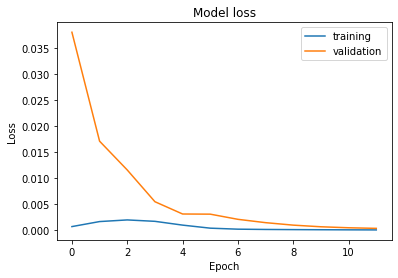

In [11]:
# Plot training
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

In [12]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# Get something which has as many features as dataset
trainPredict_extended = np.zeros((len(trainPredict),num_of_features))
# Put the predictions there
trainPredict_extended[:,pred_col] = trainPredict[:,0]
# Inverse transform it and select the 3rd column.
trainPredict = scaler.inverse_transform(trainPredict_extended) [:,pred_col]

# Get something which has as many features as dataset
testPredict_extended = np.zeros((len(testPredict),num_of_features))
# Put the predictions there
testPredict_extended[:,pred_col] = testPredict[:,0]
# Inverse transform it and select the pred_col column.
testPredict = scaler.inverse_transform(testPredict_extended)[:,pred_col] 

trainY_extended = np.zeros((len(trainY),num_of_features))
trainY_extended[:,pred_col]=trainY
trainY = scaler.inverse_transform(trainY_extended)[:,pred_col]

testY_extended = np.zeros((len(testY),num_of_features))
testY_extended[:,pred_col]=testY
testY = scaler.inverse_transform(testY_extended)[:,pred_col]

# calculate root mean squared error
trainScore_RMSE = math.sqrt(mean_squared_error(trainY, trainPredict))
testScore_RMSE = math.sqrt(mean_squared_error(testY, testPredict))

# calculate absolute mean error
trainScore_MAE = np.sum(np.absolute(trainY - trainPredict))/len(trainY)
testScore_MAE = np.sum(np.absolute(testY - testPredict))/len(testY)

130/130 [==============================] - 5s 40ms/step


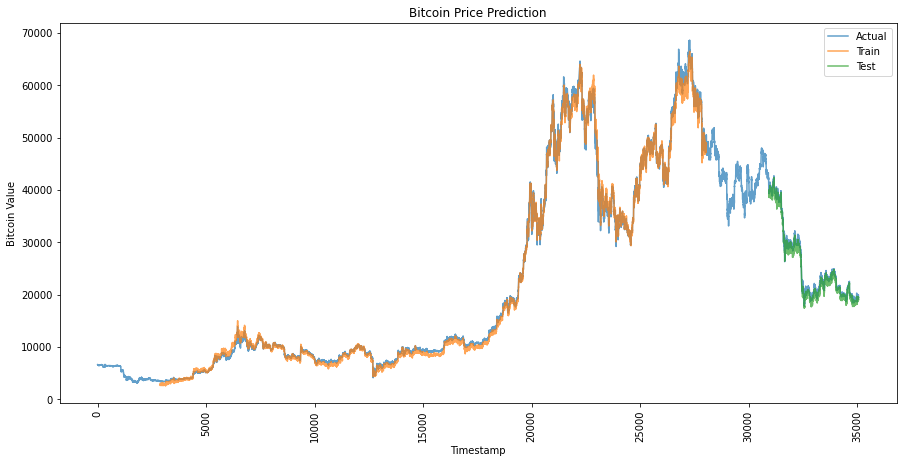

In [13]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, pred_col] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, pred_col] = testPredict

# contruct pandas dataframe for plotting
time_df = pd.DataFrame(org_df.index)
time_df['Actual'] = scaler.inverse_transform(dataset)[:,pred_col]
df1 = pd.DataFrame(trainPredictPlot[:,pred_col],columns=['Train'])
df2 = pd.DataFrame(testPredictPlot[:,pred_col],columns=['Test'])
time_df2 = pd.concat([time_df, df1, df2], axis=1, sort=False)
#time_df2.set_index('timestamp',inplace=True)

# plot the output
fig, ax = plt.subplots(figsize=(15,7))
time_df2.plot(ax=ax,rot=90,alpha=0.7)
plt.xlabel('Timestamp')
plt.ylabel('Bitcoin Value')
plt.title('Bitcoin Price Prediction')
plt.savefig(expr_name + '.png',bbox_inches = "tight")

In [15]:
print('-' * 50)
print('Experiment name:', expr_name)

print('-' * 50)
print('look_back days:', look_back/24)
print('lstm_layers:', lstm_layers)
print('epochs:', epochs)
print('batch_size:', batch_size)
print('dataset features', list(org_df.columns))


print('-' * 50)
print('Train Score: %.2f RMSE' % (trainScore_RMSE))
print('Test Score: %.2f RMSE' % (testScore_RMSE))

print('-' * 50)
print('Train Score: %.2f MAE' % (trainScore_MAE))
print('Test Score: %.2f MAE' % (testScore_MAE))

print('-' * 50)
print('Model summary:')
model.summary()

--------------------------------------------------
Experiment name: expr_4
--------------------------------------------------
look_back days: 120.0
lstm_layers: 64
epochs: 12
batch_size: 128
dataset features ['open_BTCUSD', 'high_BTCUSD', 'low_BTCUSD', 'close_BTCUSD', 'volume_BTCUSD', 'close_LTCUSD', 'volume_LTCUSD', 'close_ETHUSD', 'volume_ETHUSD', 'flair', 'tb_polarity', 'tb_subjectivity', 'sid_pos', 'sid_neg']
--------------------------------------------------
Train Score: 815.36 RMSE
Test Score: 786.02 RMSE
--------------------------------------------------
Train Score: 605.89 MAE
Test Score: 686.34 MAE
--------------------------------------------------
Model summary:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                20224     
                                                                 
 dense (Dense)               (None,

In [16]:
df = np.column_stack((testY, testPredict))
df = pd.DataFrame(df, columns= ['actual', 'predicted'])

In [17]:
df.to_csv("actual_vs_predictedPR.csv", index = False)